<a href="https://colab.research.google.com/github/singhnidh/Plant-disease-detection-using-Deep-Learning-and-Machine-Vision/blob/main/Model/2_FINAL_Resnet_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
NUM_CLASSES = 20

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1



image_size = IMAGE_RESIZE
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset')

train_data_dir = download_dir/' dataset_original'
test_data_dir = download_dir/' Augmented Dataset'

class_subset = os.listdir(download_dir/' dataset_original')
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/my_model_tl_ft_res333.keras', monitor = 'val_loss', save_best_only = True,
                             mode='min',
                             save_freq=1,
                             verbose=1)

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights='imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
#model.layers[0].trainable = False
for layer in model.layers[:-2]:
    layer.trainable = False
model.summary()
from tensorflow.keras.optimizers import SGD

#from tensorflow.keras import optimizers
import tensorflow as tf
#sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

sgd = tf.keras.optimizers.legacy.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)
fit_history = model.fit(
        traingen,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validgen,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.save("/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/my_model_tl_ft_res333.keras")

print(fit_history.history.keys())

Found 16545 images belonging to 20 classes.
Found 2911 images belonging to 20 classes.
Found 10472 images belonging to 20 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 20)                40980     
                                                                 
Total params: 23628692 (90.14 MB)
Trainable params: 23575572 (89.93 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
Epoch 1/10


 1/10 [==>...........................] - ETA: 8:11 - loss: 3.2571 - accuracy: 0.0625

 2/10 [=====>........................] - ETA: 4:31 - loss: 3.2003 - accuracy: 0.0703

 3/10 [========>.....................] - ETA: 4:11 - loss: 3.0432 - accuracy: 0.0885

 4/10 [===========>..................] - ETA: 3:30 - loss: 2.8820 - accuracy: 0.1445

 5/10 [==============>...............] - ETA: 2:53 - loss: 2.7860 - accuracy: 0.1719

 6/10 [=================>............] - ETA: 2:17 - loss: 2.6281 - accuracy: 0.2266

 7/10 [====================>.........] - ETA: 1:42 - loss: 2.5365 - accuracy: 0.2612

 8/10 [=======================>......] - ETA: 1:08 - loss: 2.3847 - accuracy: 0.3066

 9/10 [==========================>...] - ETA: 34s - loss: 2.2910 - accuracy: 0.3333 

10/10 [==============================] - 544s 54s/step - loss: 2.1796 - accuracy: 0.3594 - val_loss: 3.9453 - val_accuracy: 0.2031
Epoch 2/10


 1/10 [==>...........................] - ETA: 7:12 - loss: 1.0523 - accuracy: 0.6562

 2/10 [=====>........................] - ETA: 4:37 - loss: 0.9607 - accuracy: 0.7109

 3/10 [========>.....................] - ETA: 3:59 - loss: 0.9152 - accuracy: 0.7292

 4/10 [===========>..................] - ETA: 3:25 - loss: 0.8599 - accuracy: 0.7461

 5/10 [==============>...............] - ETA: 2:50 - loss: 0.8307 - accuracy: 0.7625

 6/10 [=================>............] - ETA: 2:16 - loss: 0.7791 - accuracy: 0.7786

 7/10 [====================>.........] - ETA: 1:42 - loss: 0.7519 - accuracy: 0.7857

 8/10 [=======================>......] - ETA: 1:08 - loss: 0.7368 - accuracy: 0.7832

 9/10 [==========================>...] - ETA: 33s - loss: 0.6982 - accuracy: 0.7899 

10/10 [==============================] - 445s 44s/step - loss: 0.6590 - accuracy: 0.8031 - val_loss: 57.7449 - val_accuracy: 0.1187
Epoch 3/10


 1/10 [==>...........................] - ETA: 6:36 - loss: 0.4011 - accuracy: 0.8906

 2/10 [=====>........................] - ETA: 4:33 - loss: 0.4509 - accuracy: 0.8516

 3/10 [========>.....................] - ETA: 4:02 - loss: 0.4220 - accuracy: 0.8698

 4/10 [===========>..................] - ETA: 3:26 - loss: 0.4910 - accuracy: 0.8320

 5/10 [==============>...............] - ETA: 2:50 - loss: 0.4276 - accuracy: 0.8562

 6/10 [=================>............] - ETA: 2:15 - loss: 0.3945 - accuracy: 0.8698

 7/10 [====================>.........] - ETA: 1:41 - loss: 0.4193 - accuracy: 0.8683

 8/10 [=======================>......] - ETA: 1:07 - loss: 0.4414 - accuracy: 0.8574

 9/10 [==========================>...] - ETA: 33s - loss: 0.4328 - accuracy: 0.8559 

10/10 [==============================] - 491s 50s/step - loss: 0.4421 - accuracy: 0.8516 - val_loss: 13.2308 - val_accuracy: 0.1703
Epoch 4/10


 1/10 [==>...........................] - ETA: 6:58 - loss: 0.4172 - accuracy: 0.8281

 2/10 [=====>........................] - ETA: 4:29 - loss: 0.4216 - accuracy: 0.8203

 3/10 [========>.....................] - ETA: 3:58 - loss: 0.3990 - accuracy: 0.8385

 4/10 [===========>..................] - ETA: 3:25 - loss: 0.4386 - accuracy: 0.8359

 5/10 [==============>...............] - ETA: 2:50 - loss: 0.4509 - accuracy: 0.8406

 6/10 [=================>............] - ETA: 2:16 - loss: 0.4286 - accuracy: 0.8438

 7/10 [====================>.........] - ETA: 1:41 - loss: 0.3996 - accuracy: 0.8571

 8/10 [=======================>......] - ETA: 1:07 - loss: 0.3922 - accuracy: 0.8672

 9/10 [==========================>...] - ETA: 34s - loss: 0.3725 - accuracy: 0.8698 

10/10 [==============================] - 496s 50s/step - loss: 0.3602 - accuracy: 0.8766 - val_loss: 33.5547 - val_accuracy: 0.1797
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

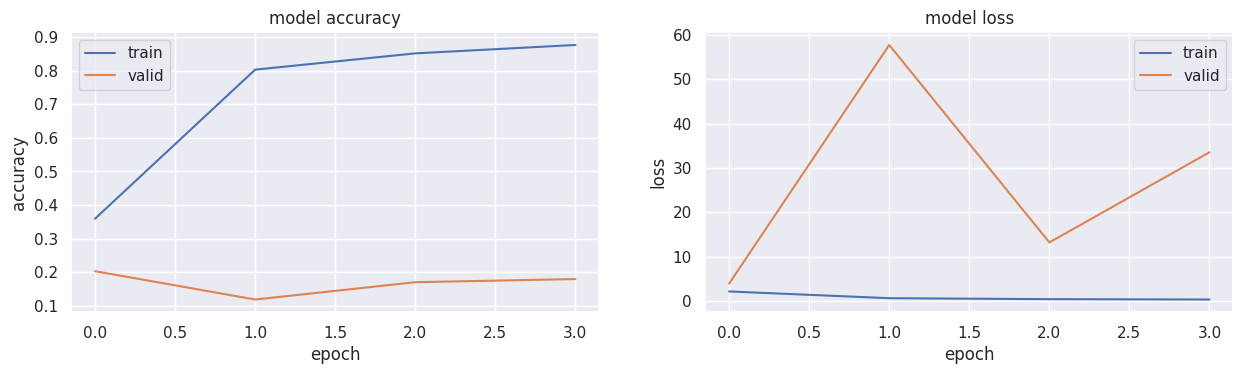

In [ ]:

plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
# Generate predictions
#model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(testgen)
pred_classes = np.argmax(preds, axis=1)

  254/10472 [..............................] - ETA: 22:35

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_classes, pred_classes)
print("Model Accuracy with Fine-Tuning: {:.2f}%".format(acc * 100))

Model Accuracy with Fine-Tuning: 47.14%


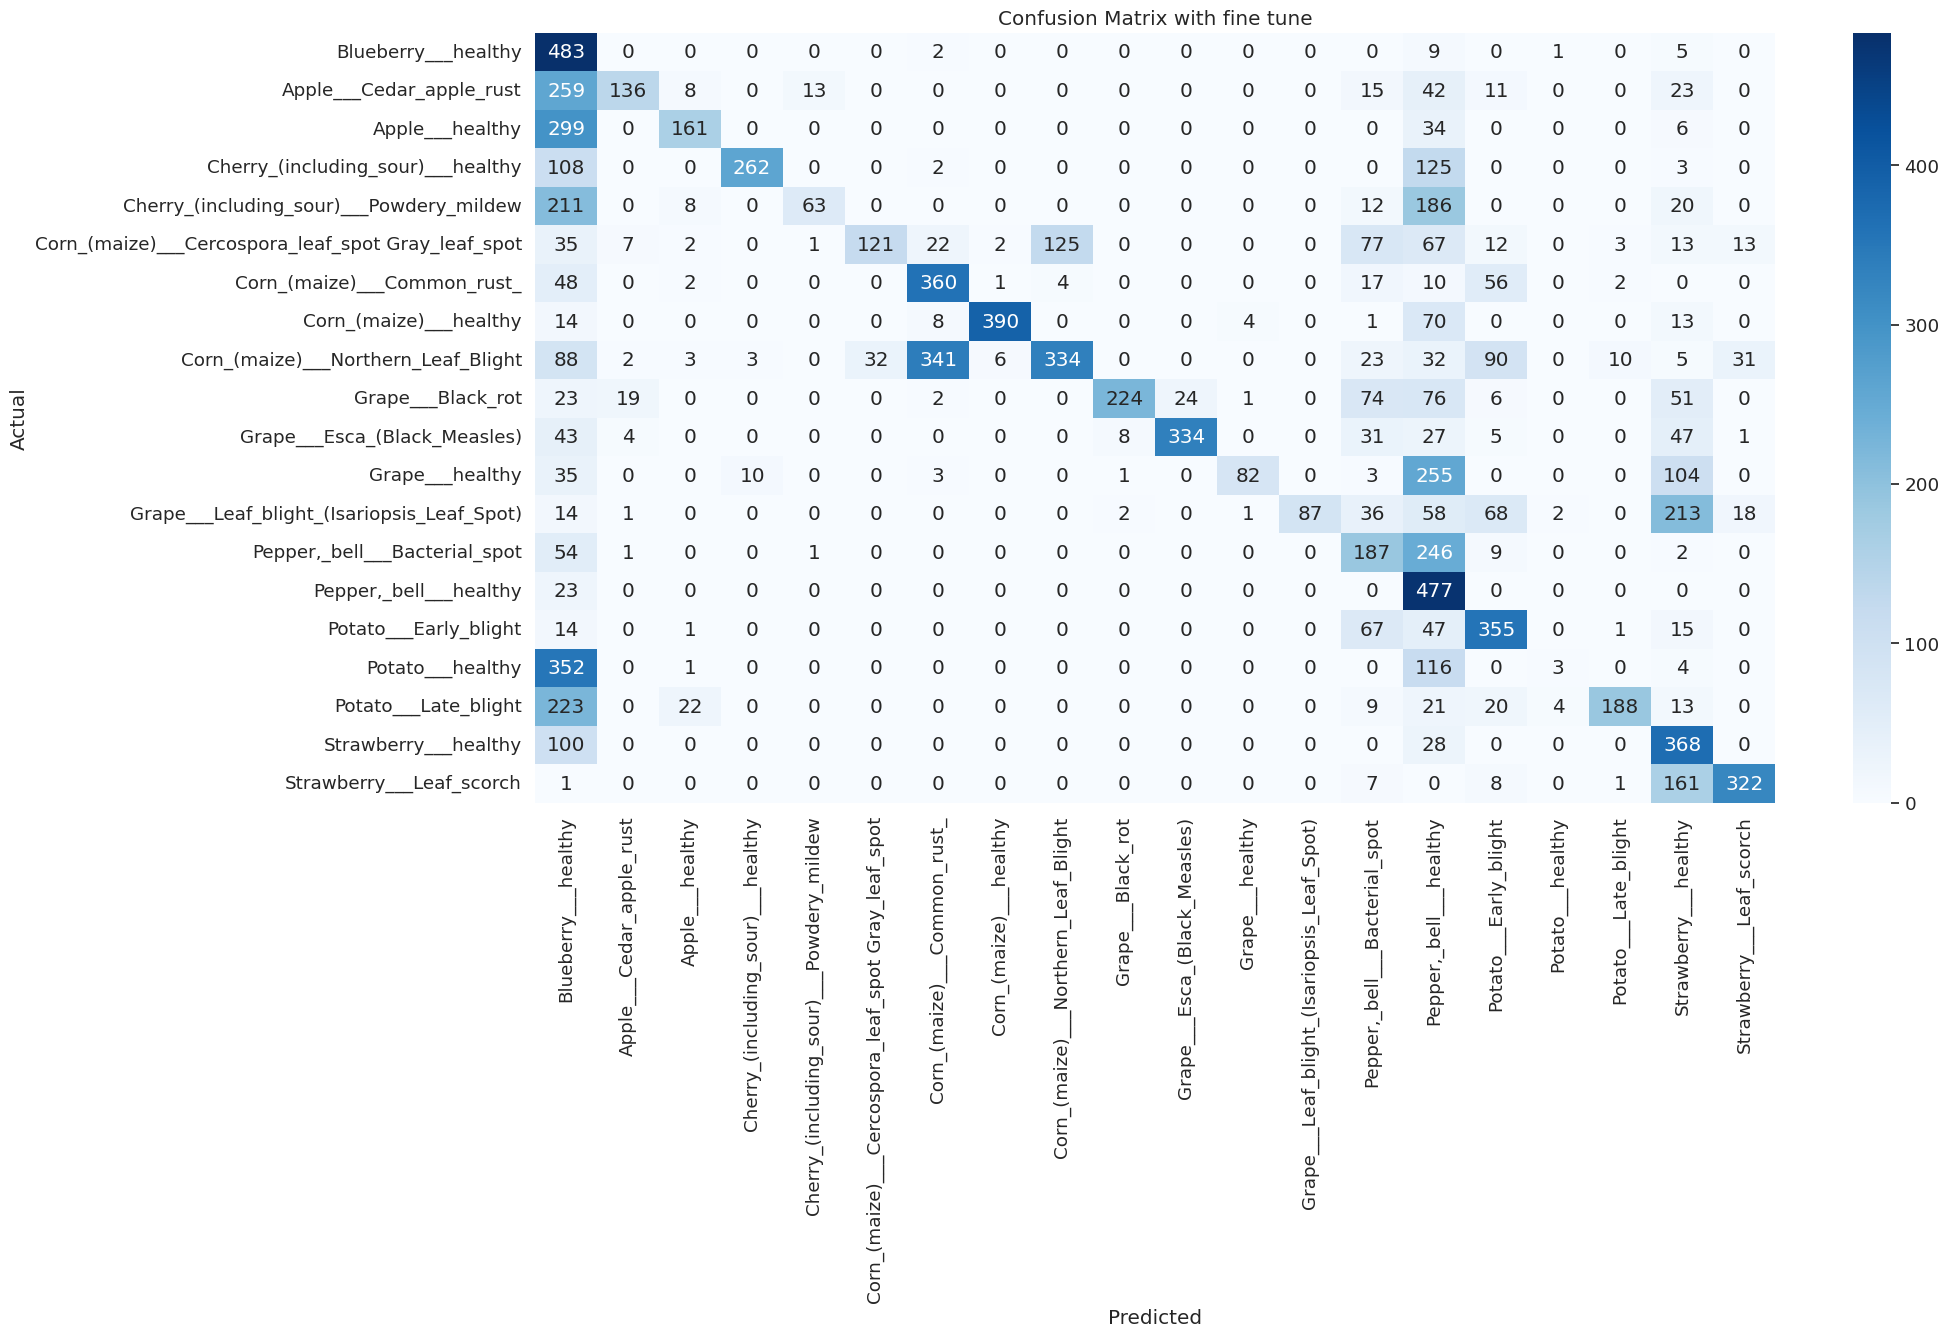

In [ ]:
cm = confusion_matrix(true_classes, pred_classes)
class_names = testgen.class_indices.keys()
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


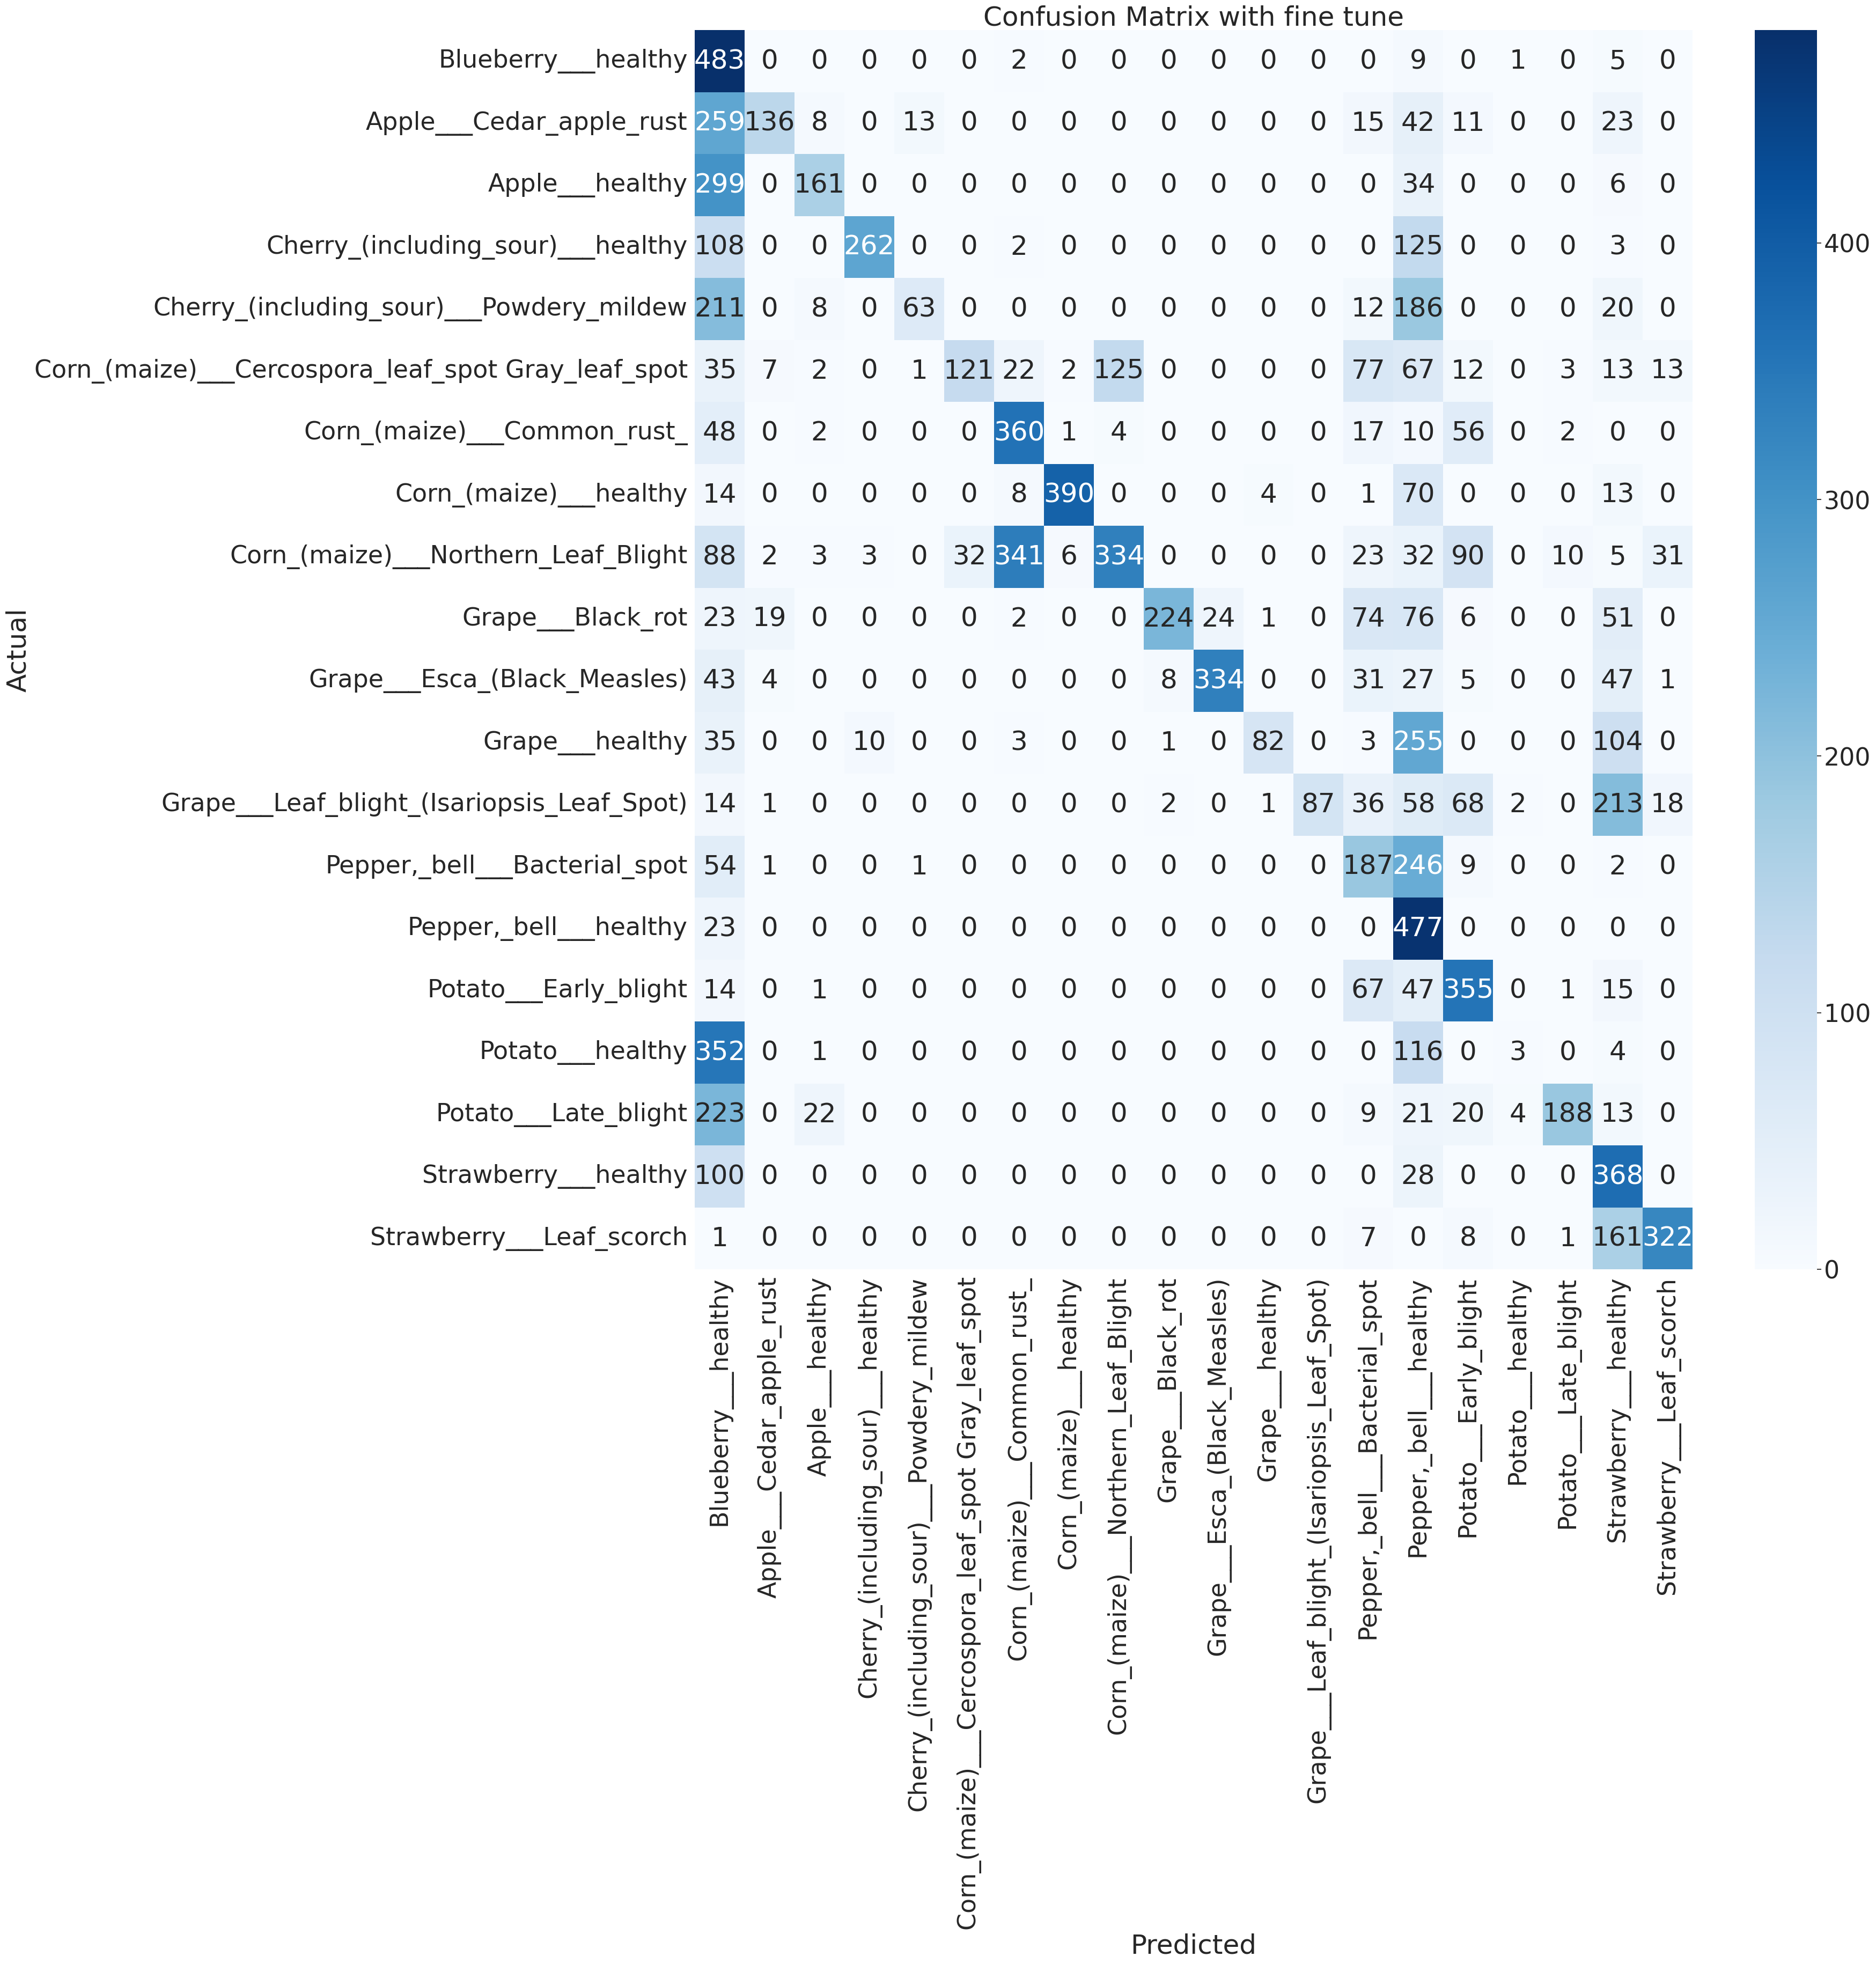

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()
# Create a heatmap
plt.figure(figsize=(30,30))
sns.set(font_scale=3)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


In [ ]:
y_pred = preds
y_true = testgen.classes
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
classification_rep = classification_report(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_rep)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


Confusion Matrix:
[[483   0   0   0   0   0   2   0   0   0   0   0   0   0   9   0   1   0
    5   0]
 [259 136   8   0  13   0   0   0   0   0   0   0   0  15  42  11   0   0
   23   0]
 [299   0 161   0   0   0   0   0   0   0   0   0   0   0  34   0   0   0
    6   0]
 [108   0   0 262   0   0   2   0   0   0   0   0   0   0 125   0   0   0
    3   0]
 [211   0   8   0  63   0   0   0   0   0   0   0   0  12 186   0   0   0
   20   0]
 [ 35   7   2   0   1 121  22   2 125   0   0   0   0  77  67  12   0   3
   13  13]
 [ 48   0   2   0   0   0 360   1   4   0   0   0   0  17  10  56   0   2
    0   0]
 [ 14   0   0   0   0   0   8 390   0   0   0   4   0   1  70   0   0   0
   13   0]
 [ 88   2   3   3   0  32 341   6 334   0   0   0   0  23  32  90   0  10
    5  31]
 [ 23  19   0   0   0   0   2   0   0 224  24   1   0  74  76   6   0   0
   51   0]
 [ 43   4   0   0   0   0   0   0   0   8 334   0   0  31  27   5   0   0
   47   1]
 [ 35   0   0  10   0   0   3   0   0   1   0  

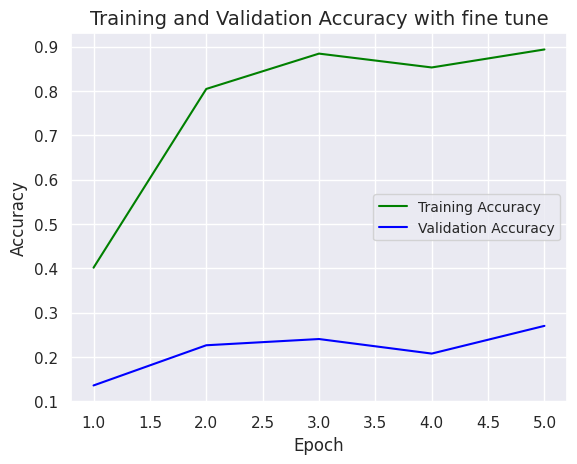

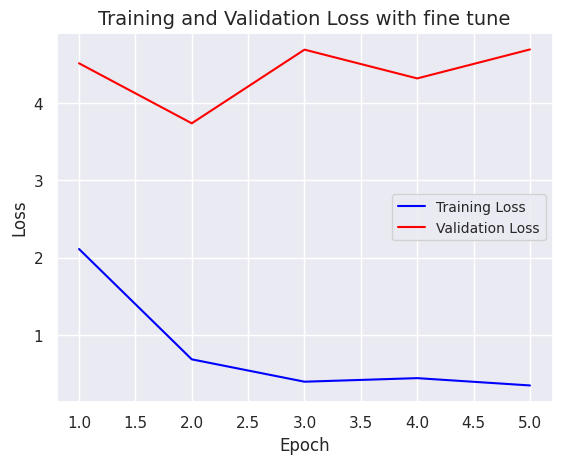

In [ ]:
sns.set()
font_scale=0.5
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy with fine tune',fontsize=14)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(fontsize=10)

plt.figure()
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss with fine tune',fontsize=14)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend(fontsize=10)

plt.show()


1/1 [==============================] - 0s 145ms/step


Text(0.5, 1.0, 'predicted: 0')

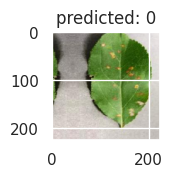

In [ ]:

# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Apple___Cedar_apple_rust/aug_0_3915.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=3
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)


Using Pre-trained Layers for Fine-Tuning